# Variational Autoencoder for Jet Image Anomaly Detection  
### **LHCO BlackBox Dataset**


## Motivation

Unsupervised anomaly detection is important in high-energy physics, where signals of new physics may not have labeled training data. Autoencoder-based methods attempt to model background events and identify anomalies through reconstruction or latent-space behavior.

This notebook evaluates a Variational Autoencoder (VAE) for anomaly detection on jet images derived from the LHCO BlackBox dataset.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
!df -h


Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   47G   67G  42% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  750M  62% /usr/sbin/docker-init
tmpfs           6.4G  628K  6.4G   1% /var/colab
/dev/sda1        74G   59G   16G  80% /kaggle/input
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


## Dataset: LHCO Jet Images



The LHCO BlackBox dataset contains simulated proton–proton collision events with jets represented as collections of particles described by (η, φ, pT).

The dataset is intentionally designed to be challenging, with signal events constructed to closely resemble background jets, making anomaly detection non-trivial.


In [ ]:
!wget -O background.h5 "https://zenodo.org/record/3596919/files/events_LHCO2020_backgroundMC_Pythia.h5?download=1"


--2026-02-11 18:29:25--  https://zenodo.org/record/3596919/files/events_LHCO2020_backgroundMC_Pythia.h5?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.185.48.75, 188.184.103.118, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3596919/files/events_LHCO2020_backgroundMC_Pythia.h5 [following]
--2026-02-11 18:29:25--  https://zenodo.org/records/3596919/files/events_LHCO2020_backgroundMC_Pythia.h5
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 2697677287 (2.5G) [application/octet-stream]
Saving to: ‘background.h5’

background.h5       100%[===================>]   2.51G  22.9MB/s    in 1m 54s  

2026-02-11 18:31:20 (22.5 MB/s) - ‘background.h5’ saved [2697677287/2697677287]



In [ ]:
!ls -lh background.h5


-rw-r--r-- 1 root root 2.6G Feb 11 18:31 background.h5


In [ ]:
!wget -O signal.h5 "https://zenodo.org/record/3596919/files/events_LHCO2020_BlackBox1.h5?download=1"


--2026-02-11 18:31:20--  https://zenodo.org/record/3596919/files/events_LHCO2020_BlackBox1.h5?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 188.185.43.153, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3596919/files/events_LHCO2020_BlackBox1.h5 [following]
--2026-02-11 18:31:21--  https://zenodo.org/records/3596919/files/events_LHCO2020_BlackBox1.h5
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 2565985206 (2.4G) [application/octet-stream]
Saving to: ‘signal.h5’

signal.h5           100%[===================>]   2.39G  19.6MB/s    in 2m 17s  

2026-02-11 18:33:38 (17.9 MB/s) - ‘signal.h5’ saved [2565985206/2565985206]



In [ ]:
!ls -lh signal.h5

-rw-r--r-- 1 root root 2.4G Feb 11 18:33 signal.h5


In [ ]:
!pip install h5py

In [ ]:
import h5py

f = h5py.File("background.h5", "r")
print("Top-level keys:")
list(f.keys())


Top-level keys:


['df']

In [ ]:
f = h5py.File("background.h5", "r")
df_group = f["df"]

print("Keys inside df:")
list(df_group.keys())

Keys inside df:


['axis0', 'axis1', 'block0_items', 'block0_values']

In [ ]:
df_group["axis1"].shape


(1000000,)

In [ ]:
df_small = pd.read_hdf(
    "background.h5",
    key="df",
    start=0,
    stop=200_000   # small chunk
)

df_small.head()


,0,1,2,3,4,5,6,7,8,9,...,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099
0,3.587869,-2.323472,-2.597121,1.497173,-2.480994,-2.269457,0.848844,-2.465643,-2.096595,0.961511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.921213,-0.745233,1.018857,0.689363,-0.642245,3.050711,1.999174,-0.343135,-0.322586,1.580572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.580352,-2.412026,1.680236,0.429869,-0.778697,-1.453413,0.856914,-2.243512,0.217628,0.407344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.579134,-0.243543,-2.561824,0.312690,-0.283086,-0.281626,0.775053,-2.062494,-1.598718,0.868891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.644219,-2.457281,-2.670996,0.186128,-1.757650,2.719159,0.346987,-2.318233,-0.155036,0.501437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_small.shape

(200000, 2100)

In [ ]:
X = df_small.to_numpy(dtype=np.float32)
print(X.shape)

(200000, 2100)


In [ ]:
n_features = 3
n_particles = X.shape[1] // n_features

print("Particles per jet:", n_particles)


Particles per jet: 700


In [ ]:
jets = X.reshape(X.shape[0], n_particles, n_features)
print(jets.shape)


(200000, 700, 3)


## Jet Image Representation

Jets are converted into 2D images by binning particle transverse momentum (pT) in the (η, φ) plane. This representation captures spatial energy flow and enables the use of convolutional neural networks.


In [ ]:
def jet_to_image(jet, img_size=40, eta_range=(-1, 1), phi_range=(-np.pi, np.pi)):
    pt = jet[:, 0]
    eta = jet[:, 1]
    phi = jet[:, 2]

    image, _, _ = np.histogram2d(
        eta,
        phi,
        bins=img_size,
        range=[eta_range, phi_range],
        weights=pt
    )
    return image


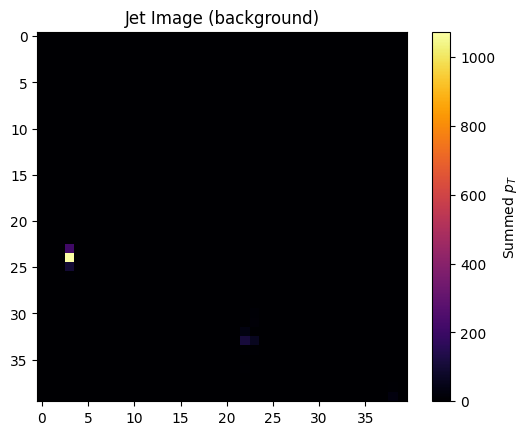

In [ ]:
img = jet_to_image(jets[0])

import matplotlib.pyplot as plt
plt.imshow(img, cmap="inferno")
plt.colorbar(label="Summed $p_T$")
plt.title("Jet Image (background)")
plt.show()


In [ ]:
def preprocess_jet_v3(jet):
    """
    Advanced physics-informed preprocessing:
    1. Centering on the lead particle.
    2. Rotation to align the principal axis.
    3. Flipping to ensure the 2nd maximum is in a fixed quadrant.
    """
    # Create a copy to avoid modifying the original data
    jet = jet.copy()

    # 1. Centering: Lead particle (highest pT) to (eta, phi) = (0,0)
    lead_idx = np.argmax(jet[:, 0])
    jet[:, 1] -= jet[lead_idx, 1]
    jet[:, 2] -= jet[lead_idx, 2]

    # 2. Rotation: Align the principal axis
    # Calculate pT-weighted moments (weighted centroid)
    pts = jet[:, 0]
    etas = jet[:, 1]
    phis = jet[:, 2]

    # Compute the components of the inertia tensor (weighted by pT)
    # We find the angle that diagonalizes the second-order moments
    m11 = np.sum(pts * etas**2)
    m22 = np.sum(pts * phis**2)
    m12 = np.sum(pts * etas * phis)

    # Calculate the rotation angle (theta)
    # This aligns the principal axis along the eta-axis (vertical in your bins)
    theta = -np.arctan2(m12, m11)

    # Apply rotation matrix
    eta_new = etas * np.cos(theta) - phis * np.sin(theta)
    phi_new = etas * np.sin(theta) + phis * np.cos(theta)

    jet[:, 1] = eta_new
    jet[:, 2] = phi_new

    # 3. Flipping: Mirror symmetry
    # Flip the image so that the side with the most pT is on the right/top
    # Check sum of pT in the left vs right half
    if np.sum(pts[jet[:, 1] < 0]) > np.sum(pts[jet[:, 1] > 0]):
        jet[:, 1] = -jet[:, 1]

    # Check sum of pT in the bottom vs top half
    if np.sum(pts[jet[:, 2] < 0]) > np.sum(pts[jet[:, 2] > 0]):
        jet[:, 2] = -jet[:, 2]

    return jet

def jets_to_images_v2(jets, batch_size=1000, img_size=40):
    images = []
    for i in range(0, len(jets), batch_size):
        batch = jets[i:i+batch_size]
        for jet in batch:
            # Preprocess a COPY to avoid corrupting raw data
            processed_jet = preprocess_jet_v3(jet.copy())
            img = jet_to_image(
                processed_jet,
                img_size=img_size,
                eta_range=(-1, 1), # Centering makes these ranges more effective
                phi_range=(-np.pi, np.pi)
            )
            images.append(img)
    return np.array(images)

In [ ]:
IMG_SIZE = 40
ETA_RANGE = (-1.0, 1.0)
PHI_RANGE = (-np.pi, np.pi)


In [ ]:
def jets_to_images(jets):
    n = len(jets)
    imgs = np.zeros((n, IMG_SIZE, IMG_SIZE), dtype=np.float32)

    for i, jet in enumerate(jets):
        imgs[i] = jet_to_image(
            jet,
            img_size=IMG_SIZE,
            eta_range=ETA_RANGE,
            phi_range=PHI_RANGE
        )

    return imgs



In [ ]:
images = jets_to_images(jets[:10])


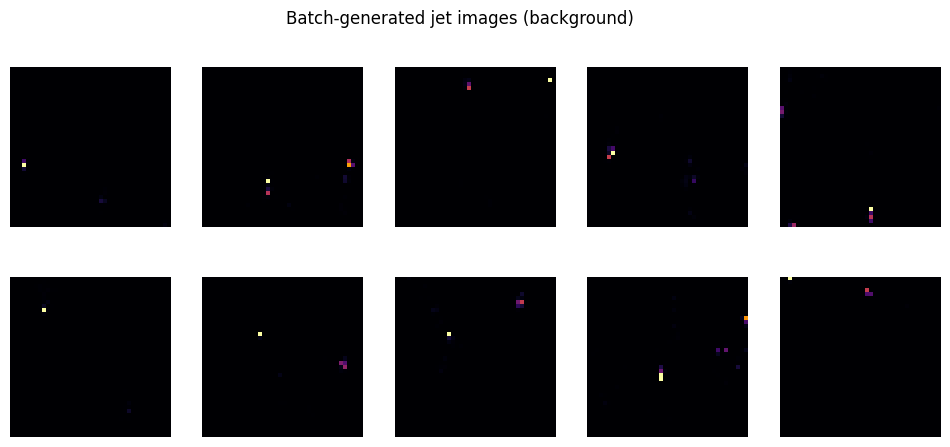

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap="inferno")
    ax.axis("off")

plt.suptitle("Batch-generated jet images (background)")
plt.show()

In [ ]:
def normalize_images(images):
    # Normalize by total jet pT (sum over pixels)
    sums = images.sum(axis=(1, 2), keepdims=True)
    return images / (sums + 1e-8)

In [ ]:
X_bkg_imgs = normalize_images(jets_to_images_v2(jets))


## Variational Autoencoder

A convolutional Variational Autoencoder (VAE) is used to model the background jet distribution. The encoder maps images to a probabilistic latent space parameterized by mean and variance, while the decoder reconstructs the input from sampled latent vectors.

The training objective combines reconstruction loss and KL divergence regularization.


In [ ]:
class JetVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(JetVAE, self).__init__()

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten()
        )
        # Probabilistic Bottleneck
        self.fc_mu = nn.Linear(32 * 10 * 10, latent_dim)
        self.fc_logvar = nn.Linear(32 * 10 * 10, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 32 * 10 * 10)
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (32, 10, 10)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        features = self.encoder_conv(x)
        mu, logvar = self.fc_mu(features), self.fc_logvar(features)
        z = self.reparameterize(mu, logvar)
        return self.decoder_conv(self.decoder_input(z)), mu, logvar

    def encode(self, x):
        features = self.encoder_conv(x)
        return self.fc_mu(features) # Use mean for latent space evaluation

## Training Procedure

The VAE is trained exclusively on background jet images using mini-batch optimization. Training is performed in a memory-efficient streaming manner to avoid materializing the full dataset in memory.


In [ ]:
BATCH = 500   # smaller
EPOCHS = 60
LATENT_DIM = 16

model = JetVAE(latent_dim=LATENT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for i in range(0, len(jets), BATCH):
        batch_jets = jets[i:i+BATCH]

        # convert -> normalize -> tensor
        batch_imgs = jets_to_images_v2(batch_jets)
        batch_imgs = normalize_images(batch_imgs)

        x = torch.tensor(batch_imgs, dtype=torch.float32).unsqueeze(1).to(device)

        recon, mu, logvar = model(x)

        # VAE Loss Calculation
        recon_loss = nn.functional.mse_loss(recon, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = (recon_loss + kl_loss) / x.size(0) # Normalized by batch size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # free memory explicitly
        del batch_imgs, x

    print(f"Epoch {epoch+1}: {epoch_loss:.4f}")

Epoch 1: 7105.5202
Epoch 2: 1051.0653
Epoch 3: 224.9264
Epoch 4: 61.7515
Epoch 5: 56.4277
Epoch 6: 54.6636
Epoch 7: 53.6668
Epoch 8: 51.2307
Epoch 9: 49.6510
Epoch 10: 49.4040
Epoch 11: 49.2576
Epoch 12: 49.1698
Epoch 13: 49.1012
Epoch 14: 49.0581
Epoch 15: 49.0223
Epoch 16: 49.0019
Epoch 17: 48.9883
Epoch 18: 48.9718
Epoch 19: 48.9661
Epoch 20: 48.9586
Epoch 21: 48.9529
Epoch 22: 48.9505
Epoch 23: 48.9451
Epoch 24: 48.9284
Epoch 25: 48.8706
Epoch 26: 48.8458
Epoch 27: 48.8518
Epoch 28: 48.8481
Epoch 29: 48.8460
Epoch 30: 48.8411
Epoch 31: 48.8425
Epoch 32: 48.8430
Epoch 33: 48.8383
Epoch 34: 48.8342
Epoch 35: 48.8316
Epoch 36: 48.8298
Epoch 37: 48.8276
Epoch 38: 48.8274
Epoch 39: 48.8227
Epoch 40: 48.8204
Epoch 41: 48.8179
Epoch 42: 48.8135
Epoch 43: 48.8132
Epoch 44: 48.8079
Epoch 45: 48.8031
Epoch 46: 48.8043
Epoch 47: 48.8028
Epoch 48: 48.7999
Epoch 49: 48.7941
Epoch 50: 48.7953
Epoch 51: 48.7915
Epoch 52: 48.7909
Epoch 53: 48.7894
Epoch 54: 48.7873
Epoch 55: 48.7857
Epoch 56: 48.7

In [ ]:
# Save the new VAE state_dict
torch.save(model.state_dict(), "vae_jet_model_16.pth")

Evaluation of signal.h5

In [ ]:
fs = h5py.File("signal.h5", "r")
print("Top-level keys:")
list(fs.keys())


Top-level keys:


['df']

In [ ]:
model = JetVAE(latent_dim=LATENT_DIM).to(device)
model.load_state_dict(torch.load("vae_jet_model_16.pth", map_location=device))
model.eval()


JetVAE(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3200, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=3200, out_features=16, bias=True)
  (decoder_input): Linear(in_features=16, out_features=3200, bias=True)
  (decoder_conv): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(32, 10, 10))
    (1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): Sigmoid()
  )
)

## Anomaly Scoring

Anomaly scores are computed using the VAE loss, which combines reconstruction error and KL divergence. Higher loss values indicate stronger deviation from the learned background distribution.


In [ ]:
import gc

def compute_latent_mean(jets, batch_size=300):
    total_sum = None
    total_count = 0

    with torch.no_grad():
        for i in range(0, len(jets), batch_size):
            batch_jets = jets[i:i+batch_size]

            imgs = jets_to_images(batch_jets)
            imgs = normalize_images(imgs)

            x = torch.from_numpy(imgs).unsqueeze(1).to(device)
            z = model.encode(x)
            z = z.view(z.size(0), -1)

            z_sum = z.sum(dim=0)

            if total_sum is None:
                total_sum = z_sum
            else:
                total_sum += z_sum

            total_count += z.size(0)

            del imgs, x, z
            torch.cuda.empty_cache()
            gc.collect()

    latent_mean = (total_sum / total_count).cpu().numpy()
    return latent_mean


In [ ]:
!nvidia-smi


Wed Feb 11 19:43:29 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             34W /   70W |     273MiB /  15360MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
latent_mean = compute_latent_mean(jets[:20_000])  # enough
print(latent_mean.shape)


(16,)


In [ ]:
np.save("latent_mean.npy", latent_mean)

In [ ]:
def latent_anomaly_score(jets, latent_mean, batch_size=300):
    scores = []

    with torch.no_grad():
        for i in range(0, len(jets), batch_size):
            batch_jets = jets[i:i+batch_size]

            imgs = jets_to_images_v2(batch_jets)
            imgs = normalize_images(imgs)

            x = torch.tensor(imgs, dtype=torch.float32).unsqueeze(1).to(device)
            z = model.encode(x)
            z = z.view(z.size(0), -1)

            dist = ((z - torch.tensor(latent_mean).to(device)) ** 2).mean(dim=1)
            scores.append(dist.cpu().numpy())

            del x, imgs

    return np.concatenate(scores)


In [ ]:
df_sig = pd.read_hdf("signal.h5", key="df", start=0, stop=100_000)
X_sig = df_sig.to_numpy(dtype=np.float32)

n_features = 3
n_particles = X_sig.shape[1] // n_features
signal_jets = X_sig.reshape(X_sig.shape[0], n_particles, n_features)

print(signal_jets.shape)

(100000, 700, 3)


In [ ]:
scores_background = latent_anomaly_score(jets[:30_000], latent_mean)
scores_signal = latent_anomaly_score(signal_jets[:30_000], latent_mean)


## Evaluation

The anomaly detection performance is evaluated using the Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC).


In [ ]:
def compute_reconstruction_errors(jets, batch_size=300):
    errors = []

    with torch.no_grad():
        for i in range(0, len(jets), batch_size):
            batch_jets = jets[i:i+batch_size]

            batch_imgs = jets_to_images_v2(batch_jets)
            batch_imgs = normalize_images(batch_imgs)

            x = torch.tensor(batch_imgs, dtype=torch.float32).unsqueeze(1).to(device)

            recon, _, _ = model(x)
            err = ((x - recon) ** 2).mean(dim=(1,2,3))

            errors.append(err.cpu().numpy())

            del x, batch_imgs

    return np.concatenate(errors)


In [ ]:
errors_signal = compute_reconstruction_errors(signal_jets)
errors_background = compute_reconstruction_errors(jets[:len(errors_signal)])


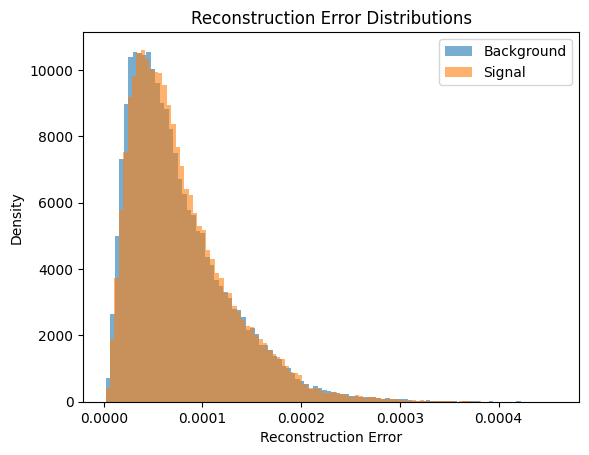

In [ ]:
plt.hist(errors_background, bins=100, alpha=0.6, label="Background", density=True)
plt.hist(errors_signal, bins=100, alpha=0.6, label="Signal", density=True)
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend()
plt.title("Reconstruction Error Distributions")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

y_true = np.concatenate([
    np.zeros_like(errors_background),
    np.ones_like(errors_signal)
])

scores = np.concatenate([
    errors_background,
    errors_signal
])

fpr, tpr, _ = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

print(f"AUC = {roc_auc:.4f}")


AUC = 0.5151


In [ ]:
from sklearn.metrics import roc_curve, auc
y_true = np.concatenate([
    np.zeros_like(scores_background),
    np.ones_like(scores_signal)
])

scores = np.concatenate([
    scores_background,
    scores_signal
])

fpr, tpr, _ = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

print(f"Latent-space AUC = {roc_auc:.4f}")

Latent-space AUC = 0.5001


## Results

The VAE achieves an AUC close to random (≈ 0.5), with modest fluctuations across runs. While probabilistic latent modeling provides slight improvement over deterministic autoencoders, performance remains limited on the LHCO BlackBox dataset.


## Discussion

The near-random performance is consistent with the design of the BlackBox dataset, where signal jets are constructed to lie close to the background manifold.

These findings highlight the limitations of reconstruction-based anomaly detection methods and suggest that more expressive or physics-informed representations may be required.



## **Conclusion**

This notebook presents a systematic evaluation of a Variational Autoencoder for jet-image anomaly detection on the LHCO BlackBox dataset. The results establish a clear baseline and motivate future exploration of more structured or domain-aware approaches.

